# CRISPR kinetic model 

This notebook demonstrates some basics of using the module after having performed the fitting procedure 
I use the data for the best fit to spCas9 data used for the manuscript as example here. 




In [2]:
# To make the plots 
%matplotlib inline 
import matplotlib.pylab as plt 
import seaborn as sns 

sns.set_style('ticks');
current_color = sns.color_palette();
sns.set_palette('Set2');


# packages you will need 
import numpy as np 
import pandas as pd 


# import the components of the kinetic model 
import sys 

sys.path.append("\\Users\\mdepk\\Documents\\CRISPR_kinetic_model\\model\\")
sys.path.append("\\Users\\mdepk\\Documents\\CRISPR_kinetic_model\\postprocessing_data\\")
sys.path.append("\\Users\\mdepk\\Documents\\CRISPR_kinetic_model\\simmulated_annealing_fit\\")
import SimmulatedAnnealing_DEP as SAfit
import active_Cas
import dead_Cas
import free_energy_landscape
import kinetic_parameters as kinpar 
from CRISPRclass import CRISPR 
import plotting_Finkelsteinlab_WA as plt_wa
import NucleaSeq
import CHAMP
import HiTS_FLIP
from importlib import reload
reload(dead_Cas);

Given we have a sequence independent parameterization, I use the following function to generate a "dummy" off-target sequence for a given mismatch pattern. 

The code is written such that it actually takes in guide and target sequences. 

In [4]:
def get_mismatched_target(on_target,mismatch_positions,Cas):
    on_target_seq = np.array(list(on_target))
    off_target = on_target_seq
    for mm in mismatch_positions:
        off_target[Cas.guide_length-mm] = 'X'
    off_target = ''.join(off_target)
    return off_target

## I picked some constant on-target sequence (the one used in NucleaSeq /CHAMP)
Not particularly relevant for the calculations here, just need some 20-mer + NGG 

In [3]:
targetE = 'GACGCATAAAGATGAGACGCTGG'

## Define the specifics of the guided nuclease you are working with 
This bit of the code allows us to just pass an instance of the CRISPR class into all functions that follow, in stead of "PAM length" + "PAM sequence" + " guide length " + ....


In [3]:
# --- initialize -------- 
Cas9 = CRISPR(guide_length=20,
                  PAM_length=3,
                  PAM_sequence='NGG')

## Let's use an example off-target 

In [5]:
off_target_seq = get_mismatched_target(on_target=targetE, 
                                       mismatch_positions=[3],
                                      Cas=Cas9)
print(off_target_seq)

GACGCATAAAGATGAGAXGCTGG


## loading in the dataset 

Add your parameterization to the "read_model_ID.py" as a new "model_ID"

In [6]:
# file_parameters =   '/Users/mdepk/Documents/CRISPR_kinetic_model/data_model/fit_18_7_2019_sim_17.txt'
file_parameters =   '/Users/mdepk/Documents/CRISPR_kinetic_model/DEP/test_Results_run2.txt'


Cas_params, dCas_params, epsilon, forward_rates, kon, kf, kcat= kinpar.kinetic_parameters(file_parameters,
                                                      ID_Cas="Clv_Saturated_general_energies_v2",
                                                    ID_dCas="general_energies_no_kPR",
                                                                              concentration_nM=10.,
                                                                              nmbr_fit_params=44)



C:\Programs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


## Display free-energy landscape 

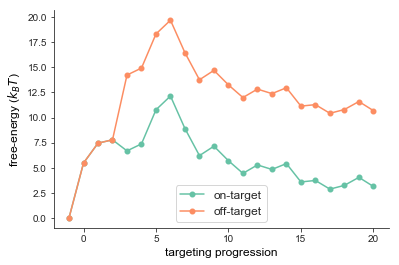

In [7]:
# --- extract the free-energy landscape with the following function --- 
landscape_on_target = free_energy_landscape.plot_landscape(guide=targetE,target=targetE,epsilon=epsilon, 
                                                          Cas=Cas9,show_plot=False);

landscape_off_target = free_energy_landscape.plot_landscape(guide=targetE,target=off_target_seq,epsilon=epsilon, 
                                                          Cas=Cas9,show_plot=False);


# --- Now just plot it (the built-in "show_plot" can be used if you just want to show a single landscape) --- 

# NOTE: The range(-1,21) signifies the number of states in the kinetic model of Cas9 
plt.plot(range(-1,21), landscape_on_target, 
        marker="o",
        markersize=4,
        markeredgewidth=2,
        label='on-target');


plt.plot(range(-1,21), landscape_off_target, 
        marker="o",
        markersize=4,
        markeredgewidth=2,
        label='off-target');


plt.legend(fontsize=12, frameon=True, loc='lower center');
plt.xlabel('targeting progression', fontsize=12, color='black');
plt.ylabel(r'free-energy ($k_{B}T$)', fontsize=12, color='black');
sns.despine();

## Calculate fraction of cut DNA over time 
The module "active_Cas.py" contains functions to determine bulk/single-molecule kinetics related to cleavage 

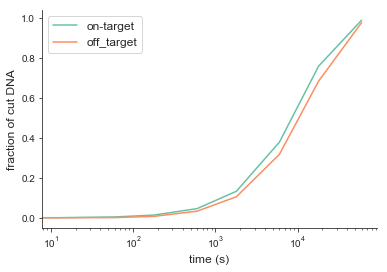

In [45]:


# --- give some range of timepoints, here the same we use for NucleaSeq --- 
timepoints = np.array([0.0, 12.0, 60.0, 180.0, 600.0, 1800.0, 6000.0, 18000.0, 60000.0])

# --- the following function does the trick  :-) ---- 
ProbCLV_on_target = active_Cas.calc_fraction_cleaved(guide=targetE, 
                                               target=targetE, 
                                               epsilon=epsilon, 
                                               forward_rates=forward_rates,
                                               Cas=Cas9, 
                                               timepoints=timepoints)

ProbCLV_off_target = active_Cas.calc_fraction_cleaved(guide=targetE, 
                                               target=off_target_seq, 
                                               epsilon=epsilon, 
                                               forward_rates=forward_rates,
                                               Cas=Cas9, 
                                               timepoints=timepoints)



# -- to visualize --- 
plt.semilogx(timepoints, ProbCLV_on_target, label='on-target')
plt.semilogx(timepoints, ProbCLV_off_target, label='off_target')
plt.xlabel('time (s)', fontsize=12);
plt.ylabel('fraction of cut DNA', fontsize=12);
plt.legend(fontsize=12, frameon=True);
sns.despine()

## Calculate fraction of bound DNA over time (dCas)
The module "dead_Cas.py" contains functions to determine bulk/single-molecule binding kinetics of catalytically inactivated Cas. 

NOTE: There are functions with the same name in both "active_Cas.py" and "dead_Cas.py". This is intentional: The version in dead_Cas.py to solve Master Equation will first set $k_{\rm{cat}} = 0$ 

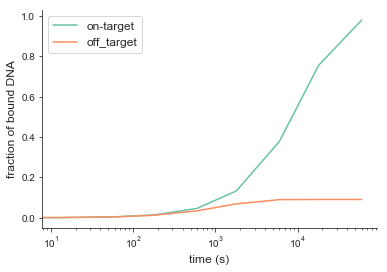

In [42]:
 # --- give some range of timepoints, here the same we use for NucleaSeq --- 
timepoints = np.array([0.0, 12.0, 60.0, 180.0, 600.0, 1800.0, 6000.0, 18000.0, 60000.0])

# --- the following function does the trick  :-) ---- 
ProbBND_on_target = dead_Cas.calc_fraction_bound(guide=targetE, 
                                               target=targetE, 
                                               epsilon=epsilon, 
                                               forward_rates=forward_rates,
                                               Cas=Cas9, 
                                               timepoints=timepoints)

ProbBND_off_target = dead_Cas.calc_fraction_bound(guide=targetE, 
                                               target=off_target_seq, 
                                               epsilon=epsilon, 
                                               forward_rates=forward_rates,
                                               Cas=Cas9, 
                                               timepoints=timepoints)



# -- to visualize --- 
plt.semilogx(timepoints, ProbBND_on_target, label='on-target')
plt.semilogx(timepoints, ProbBND_off_target, label='off_target')
plt.xlabel('time (s)', fontsize=12);
plt.ylabel('fraction of bound DNA', fontsize=12);
plt.legend(fontsize=12, frameon=True);
sns.despine()


## Determine binding curve 
Here, I invoke the "CHAMP" module to determine the binding curve verses concentration. 
Internally, this simply evaluates the previous at various concentrations (and will fit dissociation constant)

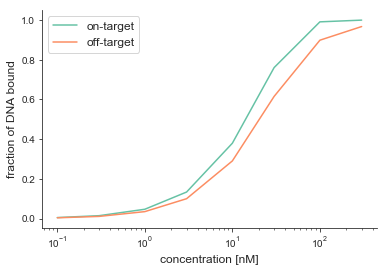

In [43]:
# --- some fixed set of concentrations: The ones used by CHAMP. Just an example  ---
concentrations = np.array([0.1,0.3,1.,3.,10.,30.,100.,300.])

#--- Record bound fraction after a fixed time of ... (in seconds)--- 
T = 10*60 


# --- once again, the function has the same format for input variables --- 
_,bnd_on_target,_ = CHAMP.binding_curve(guide=targetE, 
                                        target=targetE, 
                                        epsilon=epsilon, 
                                        forward_rates=forward_rates,
                                        concentrations=concentrations, 
                                        Cas=Cas9, 
                                        time=T)


_,bnd_off_target,_ = CHAMP.binding_curve(guide=targetE, 
                                        target=off_target_seq, 
                                        epsilon=epsilon, 
                                        forward_rates=forward_rates,
                                        concentrations=concentrations, 
                                        Cas=Cas9, 
                                        time=T)

# --- plot --- 
plt.semilogx(concentrations, bnd_on_target, label='on-target');
plt.semilogx(concentrations, bnd_off_target, label='off-target');
plt.legend(fontsize=12, frameon=True);
plt.xlabel('concentration [nM]', fontsize=12);
plt.ylabel('fraction of DNA bound', fontsize=12);
sns.despine()

## Changing concentration 

We have built functions to perform the parameter transformations needed to change the system's Cas-sgRNA concentration. 
Default is set at 1 nM. 

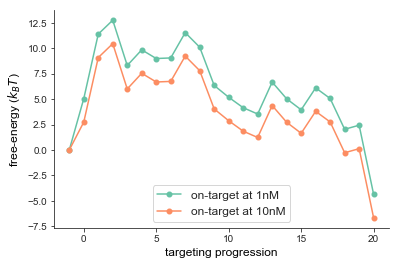

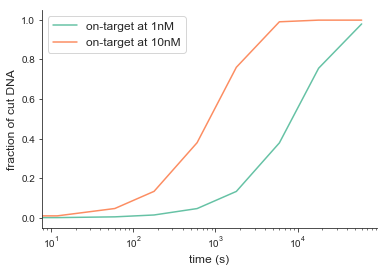

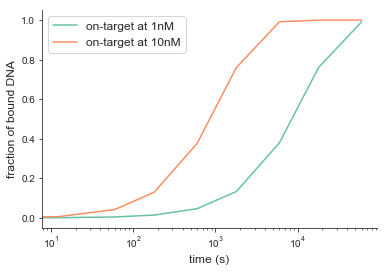

In [52]:
# --- let us switch to 10nM and observe the effect on the free-energy and kinetics --- 
concentration = 10. 

epsilon_new, forward_rates_new = kinpar.change_concentration(epsilon_1nM=epsilon,
                                                            forward_rates_1nM=forward_rates,
                                                            new_concentration=concentration)


# --- new free-energy for the on-target ---- 
landscape_new_conc = free_energy_landscape.plot_landscape(guide=targetE,target=targetE,
                                                          epsilon=epsilon_new, 
                                                          Cas=Cas9,show_plot=False);


plt.plot(range(-1,21), landscape_on_target, 
        marker="o",
        markersize=4,
        markeredgewidth=2,
        label='on-target at 1nM');


plt.plot(range(-1,21), landscape_new_conc, 
        marker="o",
        markersize=4,
        markeredgewidth=2,
        label='on-target at 10nM');


plt.legend(fontsize=12, frameon=True, loc='lower center');
plt.xlabel('targeting progression', fontsize=12, color='black');
plt.ylabel(r'free-energy ($k_{B}T$)', fontsize=12, color='black');
sns.despine();



# --- bound-fraction ---- 
timepoints = np.array([0.0, 12.0, 60.0, 180.0, 600.0, 1800.0, 6000.0, 18000.0, 60000.0])
ProbBND_new_conc = dead_Cas.calc_fraction_bound(guide=targetE, 
                                               target=targetE, 
                                               epsilon=epsilon_new, 
                                               forward_rates=forward_rates_new,
                                               Cas=Cas9, 
                                               timepoints=timepoints)

plt.figure()
plt.semilogx(timepoints, ProbBND_on_target, label='on-target at 1nM')
plt.semilogx(timepoints, ProbBND_new_conc, label='on-target at 10nM')
plt.xlabel('time (s)', fontsize=12);
plt.ylabel('fraction of cut DNA', fontsize=12);
plt.legend(fontsize=12, frameon=True);
sns.despine()



# --- cleaved-fraction --- 
ProbCLV_new_conc = active_Cas.calc_fraction_cleaved(guide=targetE, 
                                               target=targetE, 
                                               epsilon=epsilon_new, 
                                               forward_rates=forward_rates_new,
                                               Cas=Cas9, 
                                               timepoints=timepoints)

plt.figure()
plt.semilogx(timepoints, ProbCLV_on_target, label='on-target at 1nM')
plt.semilogx(timepoints, ProbCLV_new_conc, label='on-target at 10nM')
plt.xlabel('time (s)', fontsize=12);
plt.ylabel('fraction of bound DNA', fontsize=12);
plt.legend(fontsize=12, frameon=True);
sns.despine()



In [4]:
#the on-target 
targetE = 'GACGCATAAAGATGAGACGCTGG'

file_parameters =   '/Users/mdepk/Documents/CRISPR_kinetic_model/DEP/test_Results_run2.txt'

epsilon_list=[]

for n in range(0,1000):
        Cas_params, dCas_params, epsilon, forward_rates, kon, kf, kcat= kinpar.kinetic_parameters(file_parameters,
                                                                                          ID_Cas="Clv_Saturated_general_energies_v2",
                                                                                          ID_dCas="general_energies_no_kPR",
                                                                                          fatch_solution=n,
                                                                                          concentration_nM=10.,
                                                                                          nmbr_fit_params=44)
        epsilon_list.append(epsilon)



IndexError: single positional indexer is out-of-bounds

In [5]:
len(epsilon_list)

1

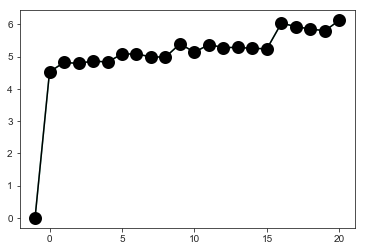

In [6]:
for epsilon in epsilon_list:
    landscape_on_target = free_energy_landscape.plot_landscape(guide=targetE,target=targetE,epsilon=epsilon, 
                                                               Cas=Cas9,show_plot=False);
    plt.plot(range(-1,21), landscape_on_target, 
             marker="o",
             markersize=4,
             markeredgewidth=2,
             label='on-target')


landscape_on_target = free_energy_landscape.plot_landscape(guide=targetE,target=targetE,epsilon=epsilon_list[-1], 
                                                               Cas=Cas9,show_plot=False);    
plt.plot(range(-1,21), landscape_on_target, 'k-',
             marker="o",
             markersize=8,
             markeredgewidth=5,
             label='on-target')


C:\Programs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


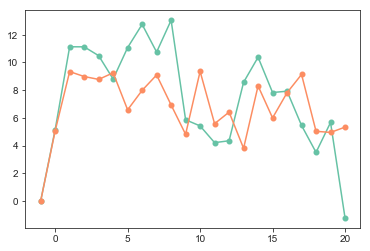

In [6]:
#file_parameters_Misha =   '/Users/mdepk/Documents/CRISPR_kinetic_model/data_model/fit_18_7_2019_sim_17.txt'
file_parameters_Misha =   '/Users/mdepk/Documents/CRISPR_kinetic_model/DEP/test_Results_run1.txt'
file_parameters_Martin =  '/Users/mdepk/Documents/CRISPR_kinetic_model/DEP/test_Results_run2.txt'

Cas_params, dCas_params, epsilon_Martin, forward_rates, kon, kf, kcat = kinpar.kinetic_parameters(file_parameters_Martin,
                                                                                          ID_Cas="Clv_Saturated_general_energies_v2",
                                                                                          ID_dCas="general_energies_no_kPR",
                                                                                          concentration_nM=10.,
                                                                                          nmbr_fit_params=44)

Cas_params, dCas_params, epsilon_Misha, forward_rates, kon, kf, kcat = kinpar.kinetic_parameters(file_parameters_Misha,
                                                                                          ID_Cas="Clv_Saturated_general_energies_v2",
                                                                                          ID_dCas="general_energies_no_kPR",
                                                                                          concentration_nM=10.,
                                                                                          nmbr_fit_params=44)

landscape_on_target_Misha=free_energy_landscape.plot_landscape(guide=targetE,target=targetE,epsilon=epsilon_Misha, 
                                                               Cas=Cas9,show_plot=False);
landscape_on_target_Martin=free_energy_landscape.plot_landscape(guide=targetE,target=targetE,epsilon=epsilon_Martin, 
                                                                Cas=Cas9,show_plot=False);

# landscape_on_target = free_energy_landscape.plot_landscape(guide=targetE,target=targetE,epsilon=epsilon,Cas=Cas9,show_plot=False);

plt.plot(range(-1,21), landscape_on_target_Misha, marker="o",markersize=4,markeredgewidth=2,label='on-target');
plt.plot(range(-1,21), landscape_on_target_Martin, marker="o", markersize=4, markeredgewidth=2,label='off-target');


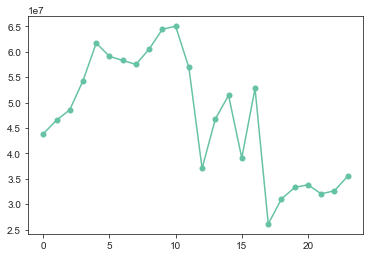

In [7]:
SAfit.plot_potev(file_parameters)

18

C:\Programs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


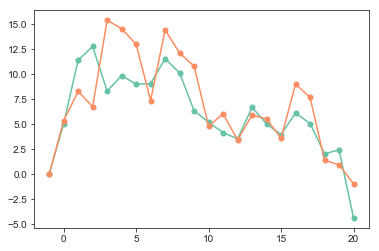

In [8]:
file_parameters_Misha =   '/Users/mdepk/Documents/CRISPR_kinetic_model/data_model/fit_18_7_2019_sim_17.txt'
file_parameters_Martin =   '/Users/mdepk/Documents/CRISPR_kinetic_model/DEP/test_Results_run2.txt'

Cas_params, dCas_params, epsilon_Martin, forward_rates, kon, kf, kcat = kinpar.kinetic_parameters(file_parameters_Martin,
                                                                                          ID_Cas="Clv_Saturated_general_energies_v2",
                                                                                          ID_dCas="general_energies_no_kPR",
                                                                                          concentration_nM=10.,
                                                                                          nmbr_fit_params=44)

Cas_params, dCas_params, epsilon_Misha, forward_rates, kon, kf, kcat = kinpar.kinetic_parameters(file_parameters_Misha,
                                                                                          ID_Cas="Clv_Saturated_general_energies_v2",
                                                                                          ID_dCas="general_energies_no_kPR",
                                                                                          concentration_nM=10.,
                                                                                          nmbr_fit_params=44)

landscape_on_target_Misha=free_energy_landscape.plot_landscape(guide=targetE,target=targetE,epsilon=epsilon_Misha, 
                                                               Cas=Cas9,show_plot=False);
landscape_on_target_Martin=free_energy_landscape.plot_landscape(guide=targetE,target=targetE,epsilon=epsilon_Martin, 
                                                                Cas=Cas9,show_plot=False);

# landscape_on_target = free_energy_landscape.plot_landscape(guide=targetE,target=targetE,epsilon=epsilon,Cas=Cas9,show_plot=False);

plt.plot(range(-1,21), landscape_on_target_Misha, marker="o",markersize=4,markeredgewidth=2,label='on-target');
plt.plot(range(-1,21), landscape_on_target_Martin, marker="o", markersize=4, markeredgewidth=2,label='off-target');


[ 0.          5.04025012 11.37396601 12.73887056  8.2942038   9.83128763
  8.97860289  9.03458082 11.52110645 10.0886472   6.33297526  5.17643042
  4.15188621  3.53224549  6.66634272  5.02319646  3.94495517  6.09886493
  5.05634546  2.03464479  2.43373412 -4.35620952]
[0.         5.25134184 7.40765488 7.99847811 8.73195093 8.16761087
 8.74094059 8.04344189 7.88428251 7.73731728 6.69980988 5.70146079
 5.22851305 4.95845149 4.24669078 4.39236014 4.8397295  4.8015528
 4.02096049 3.32318858 2.34945254 1.76138586]


In [2]:
np.random.randint(3)

2

In [1]:
output_file_results='12345678901234567890'

In [2]:
output_file_results[1:-4]+'_restart'+output_file_results[-3:]

'234567890123456_restart890'

In [7]:
print(np.random.rand(5)-0.5)

[ 0.49492278  0.10043939 -0.43126309  0.32214902 -0.10254789]
